<a href="https://colab.research.google.com/github/cjakuc/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
!pip install category_encoders==2.*
!pip install pdpbox
!pip install eli5
!pip install shap

     |████████████████████████████████| 102kB 3.9MB/s 
     |████████████████████████████████| 57.7MB 70kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=9d3cab4848cbd8dd577d9f795cb24ec01469fd293435cf8e928914bfdefebb75
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 112kB 4.7MB/s 
     |████████████████████████████████| 276kB 5.1MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394147 sha256=61d28a2057e0d7ade2a2db0fd6b2d16c0436b958e40c3404230009c4e74de5a5
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
# Import data
df = pd.read_csv('https://github.com/cjakuc/DS-Unit2_Build-Week/blob/master/Data/BuildWeek2FinalData.csv?raw=true',
                 infer_datetime_format=True,
                 index_col=0)

In [0]:
# Lagged variables add NaN values which don't allow for getting the permutation importance
# Unsure how to handle this
def wrangle(X):
  """Wrangle train, validate, and test in the same way"""

  X = X.copy()

  # Add lagged variables
  X['DailyAvgAirTemp_lag1'] = X['DailyAvgAirTemp'].shift()
  X['DailyHeatingDegreeDays_lag1'] = X['DailyHeatingDegreeDays'].shift()
  X['DailyCoolingDegreeDays_lag1'] = X['DailyCoolingDegreeDays'].shift()
  X['DailyHeatingDegreeDays_lag24'] = X['DailyHeatingDegreeDays'].shift(24)
  X['DailyCoolingDegreeDays_lag24'] = X['DailyCoolingDegreeDays'].shift(24)
  X['DailyHeatingDegreeDays_lag365'] = X['DailyHeatingDegreeDays'].shift(365)
  X['DailyCoolingDegreeDays_lag365'] = X['DailyCoolingDegreeDays'].shift(365)
  X['MW_lag1'] = X['MW'].shift()
  X['MW_lag24'] = X['MW'].shift(24)
  X['MW_lag365'] = X['MW'].shift(365)

  # Drop unattainable info
  X = X.drop(columns=['DailyAvgAirTemp',
                      'DailyHeatingDegreeDays',
                      'DailyCoolingDegreeDays'])

  return X

# Wrangle train, val, and test
df_wrangled = wrangle(df)
train_wrangled = df_wrangled[df_wrangled['year']<2014]
val_wrangled = df_wrangled[df_wrangled['year']==2014]
test_wrangled = df_wrangled[df_wrangled['year']==2015]

In [4]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import eli5
from eli5.sklearn import PermutationImportance

# Build, fit, validate, and visualize the model
def full_model(train,val):
  """Define a function that selects features, encodes,
     and fits a XGBRegressor model
     Returns the model and features"""

  # Select target
  target = 'MW'
  # Drop target from features
  features = train.drop(columns=[target,'HourlySeaLevelPressure']).columns.tolist()

  # Arrange X features matrix & y target vector
  X_train = train[features]
  y_train = train[target]
  X_val = val[features]
  y_val = val[target]

  # Encode
  encoder = ce.OrdinalEncoder()
  X_train_encoded = encoder.fit_transform(X_train)
  X_val_encoded = encoder.transform(X_val)

  # Build model
  model = XGBRegressor(n_estimators=1000,
                       max_depth=6,
                       random_state=42,
                       learning_rate=0.5,
                       n_jobs=-1,
                       verbosity=0)
  # Fit model
  eval_set = [(X_train_encoded, y_train), 
              (X_val_encoded, y_val)]

  model.fit(X_train_encoded, y_train, 
            eval_set=eval_set, 
            eval_metric='mae', 
            early_stopping_rounds=50,
            verbose=False)
  
  # Print scores
  print(f'XGB best iterations: {model.best_iteration}')
  print('Train MAE', mean_absolute_error(y_train,model.predict(X_train_encoded)))
  print('Validation MAE', mean_absolute_error(y_val,model.predict(X_val_encoded)))
  print(f'Train R^2 Score: {model.score(X_train_encoded,y_train)}')
  print(f'Validation R^2 Score: {model.score(X_val_encoded,y_val)}\n')

  # Plot the residuals
  errors = (y_val - model.predict(X_val_encoded))
  sns.scatterplot(x=y_val,y=errors,alpha=0.1)
  # Add a horizontal line at residuals = 0
  plt.hlines(y=0,xmin=1000,xmax=3200,color='red');
  plt.title('Residuals vs Validation Target')
  plt.ylabel('Residuals (MW)')
  plt.xlabel('Validation Target (MW)')
  plt.show()


  # Plot the residuals vs the actual
  import matplotlib.lines as mlines
  blue_line = mlines.Line2D([],[],color='#2077B4',
                            linewidth=3)
  orange_line = mlines.Line2D([],[],color='#FC7F0F',
                              linewidth=3)
  sns.lineplot(x=val['date'],y=val['MW'])
  sns.lineplot(x=val['date'],y=model.predict(X_val_encoded))
  plt.title('Actual vs Predicted Values')
  # Create the legend
  plt.legend(handles=[blue_line,
                      orange_line],
             labels=['Actual',
                     'Predicted']);

  # Show the permutation importances
  permuter = PermutationImportance(
      model, 
      scoring='neg_mean_absolute_error', 
      n_iter=5, 
      random_state=42
  )
  permuter.fit(X_val_encoded, y_val)
  feature_names = X_val_encoded.columns.tolist()
  permutation_importances = eli5.show_weights(
      permuter, 
      top=None, # No limit: show permutation importances for all features
      feature_names=feature_names # must be a list
  )
  permutation_importances

  return model, features, permutation_importances

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGB best iterations: 218
Train MAE 12.54840406613685
Validation MAE 18.528328255431294
Train R^2 Score: 0.9982524413598107
Validation R^2 Score: 0.995639100128557



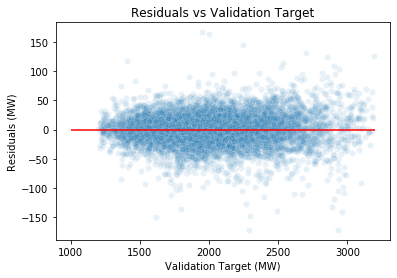

Weight,Feature
394.3762 ± 3.8062,MW_lag1
66.5403 ± 0.2895,hour
16.8519 ± 0.4480,HourlyDryBulbTemperature
5.7484 ± 0.2765,date
4.2983 ± 0.1305,DailyHeatingDegreeDays_lag24
3.2852 ± 0.1167,DailyAvgAirTemp_lag1
2.1831 ± 0.1460,HourlyDewPointTemperature
2.0806 ± 0.2513,MW_lag24
1.4313 ± 0.0936,DailyCoolingDegreeDays_lag24
1.2377 ± 0.1726,MW_lag365


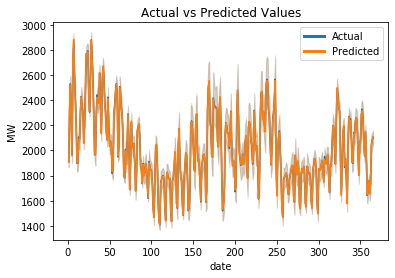

In [5]:
model, features, permutation_importances = full_model(train_wrangled,
                                                      val_wrangled)
permutation_importances

In [0]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(train_wrangled[features])
X_val_encoded = encoder.transform(val_wrangled[features])

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'hour'

isolated = pdp_isolate(
    model=model, 
    dataset=X_val_encoded, 
    model_features=X_val_encoded.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


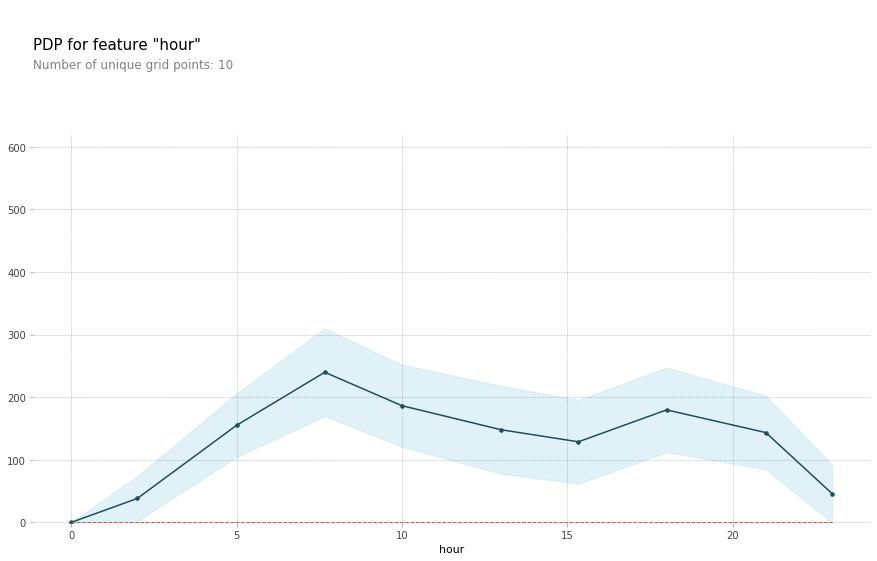

In [12]:
pdp_plot(isolated, feature_name=feature);

In [26]:
# Get an individual observation to explain.
row = X_val_encoded.iloc[[8591]] 
row

,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlyStationPressure,HourlyVisibility,HourlyWindDirection,HourlyWindSpeed,year,month,date,hour,season,DailyAvgAirTemp_lag1,DailyHeatingDegreeDays_lag1,DailyCoolingDegreeDays_lag1,DailyHeatingDegreeDays_lag24,DailyCoolingDegreeDays_lag24,DailyHeatingDegreeDays_lag365,DailyCoolingDegreeDays_lag365,MW_lag1,MW_lag24,MW_lag365
2014-12-24,35.0,39.0,0.0,86.0,28.63,10.0,230.0,16.0,2014,12,358,23,1,47.0,18.0,0.0,15.0,0.0,26.0,0.0,1754.0,1783.0,2403.0


In [27]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)